# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/EE147

Mounted at /content/drive
/content/drive/Shareddrives/EE147


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape, Permute
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
import matplotlib.pyplot as plt
import importlib

from utils.cnn_modules import inception_module, inception_module2
import utils.dataprep as dp
importlib.reload(dp)

<module 'utils.dataprep' from '/content/drive/Shareddrives/EE147/utils/dataprep.py'>

In [3]:
# Package returned variables in 'raw' variable (create new variables for each value)
raw = lambda _: ()
(raw.X_train_valid, raw.y_train_valid, _), (raw.X_test, raw.y_test, _) = dp.load_data()

print('---- Splitting Data ----')
(raw.X_train, raw.y_train), (raw.X_valid, raw.y_valid) = \
    dp.split_data(raw.X_train_valid, raw.y_train_valid)

Loading data from /content/drive/Shareddrives/EE147/project_data/
Training/Valid data shape: (2115, 22, 1000)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115, 1)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person test shape: (443, 1)
---- Splitting Data ----
Training Data: (1692, 22, 1000) with labels (1692,)
Validate Data: (423, 22, 1000) with labels (423,)


In [4]:
print('---- Augmenting Data ----')
prep = lambda _: ()
prep.X_train, prep.y_train = dp.data_prep(raw.X_train, raw.y_train, 2, 2)
print('X-train', prep.X_train.shape, 'with labels', prep.y_train.shape)
prep.X_valid, prep.y_valid = dp.data_prep(raw.X_valid, raw.y_valid, 2, 2)
print('X-valid', prep.X_valid.shape, 'with labels', prep.y_valid.shape)
prep.X_test,  prep.y_test  = dp.data_prep(raw.X_test,  raw.y_test,  2, 2)
print('X-test', prep.X_test.shape, 'with labels', prep.y_test.shape)

---- Augmenting Data ----
X-train (6768, 22, 250) with labels (6768,)
X-valid (1692, 22, 250) with labels (1692,)
X-test (1772, 22, 250) with labels (1772,)


----Getting Spectrogram----
X_train: (1692, 22, 9, 71)
X_valid: (423, 22, 9, 71)
X_test: (443, 22, 9, 71)


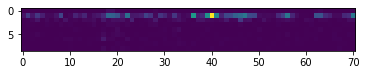

In [20]:
print('----Getting Spectrogram----')
n=16
spec = lambda _: ()
spec.X_train = dp.load_spectrogram(raw.X_train, nperseg=n)
spec.X_valid = dp.load_spectrogram(raw.X_valid, nperseg=n)
spec.X_test = dp.load_spectrogram(raw.X_test, nperseg=n)
spec.y_train = raw.y_train
spec.y_test = raw.y_test
spec.y_valid = raw.y_valid
print('X_train:', spec.X_train.shape)
print('X_valid:', spec.X_valid.shape)
print('X_test:', spec.X_test.shape)
plt.imshow(spec.X_train[0][0]); plt.show()

In [ ]:
np.stack(X[:,:,:,0], X[:,:,:,1], X[:,:,:,2])

In [21]:
X_train = spec.X_train.transpose((0, 2, 3, 1))
y_train = keras.utils.to_categorical(spec.y_train, 4)

X_valid = spec.X_valid.transpose((0, 2, 3, 1))
y_valid = keras.utils.to_categorical(spec.y_valid, 4)

X_test = spec.X_test.transpose((0, 2, 3, 1))
y_test = keras.utils.to_categorical(spec.y_test, 4)

print('---- Reshaping Data ----')
print ("X-train", X_train.shape, "with labels", y_train.shape)
print ("X-valid", X_valid.shape, "with labels", y_valid.shape)
print ("X-test", X_test.shape, "with labels", y_test.shape)

---- Reshaping Data ----
X-train (1692, 9, 71, 22) with labels (1692, 4)
X-valid (423, 9, 71, 22) with labels (423, 4)
X-test (443, 9, 71, 22) with labels (443, 4)


In [37]:
# Model parameters
dropout = 0.5
lr = 1e-3
epochs = 128
momentum = 0.9
N, H, W, T = X_train.shape

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=32, kernel_size=(2,2), padding='same', activation='relu', input_shape=(H,W,T)))
# cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(1,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=64, kernel_size=(2,2), padding='same', activation='relu'))
# cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(1,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# # Third block of conv.
# cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2,2)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(dropout))

# # Fourth block of conv.
# cnn_model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
# cnn_model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
# cnn_model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size=(2,2)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)
# optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
# cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(X_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid, y_valid), verbose=True)

Epoch 1/128
27/27 [==============================] - 1s 14ms/step - loss: 2.3001 - accuracy: 0.2606 - val_loss: 1.6009 - val_accuracy: 0.2790
Epoch 2/128
27/27 [==============================] - 0s 6ms/step - loss: 1.6072 - accuracy: 0.3657 - val_loss: 1.4862 - val_accuracy: 0.2931
Epoch 3/128
27/27 [==============================] - 0s 6ms/step - loss: 1.3767 - accuracy: 0.4488 - val_loss: 1.4406 - val_accuracy: 0.3097
Epoch 4/128
27/27 [==============================] - 0s 6ms/step - loss: 1.2271 - accuracy: 0.4961 - val_loss: 1.4620 - val_accuracy: 0.3191
Epoch 5/128
27/27 [==============================] - 0s 6ms/step - loss: 1.0377 - accuracy: 0.5732 - val_loss: 1.4954 - val_accuracy: 0.3499
Epoch 6/128
27/27 [==============================] - 0s 6ms/step - loss: 1.0132 - accuracy: 0.5818 - val_loss: 1.4562 - val_accuracy: 0.3570
Epoch 7/128
27/27 [==============================] - 0s 6ms/step - loss: 0.9541 - accuracy: 0.5967 - val_loss: 1.4897 - val_accuracy: 0.3475
Epoch 8/128
